In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%store -r

In [2]:
plt.style.use('science')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = (5,9)
plt.rcParams['figure.figsize'] = 8,6

In [3]:
import statistics as sts
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.cluster import KMeans

In [4]:
coast_train = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/coast/train.csv")
mountain_train = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/mountain/train.csv")
tallbuilding_train = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/tallbuilding/train.csv")
highway_train = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/highway/train.csv")
opencountry_train = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/opencountry/train.csv")

coast_train.drop(["image_names"],axis = 1,inplace=True)
mountain_train.drop(["image_names"],axis = 1,inplace=True)
tallbuilding_train.drop(["image_names"],axis = 1,inplace=True)
highway_train.drop(["image_names"],axis = 1,inplace=True)
opencountry_train.drop(["image_names"],axis = 1,inplace=True)

In [184]:
coast_test = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/coast/dev.csv")
mountain_test = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/mountain/dev.csv")
tallbuilding_test = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/tallbuilding/dev.csv")
highway_test = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/highway/dev.csv")
opencountry_test = pd.read_csv("/home/hp/Desktop/acads/PRML/assignment2/opencountry/dev.csv")

coast_test.drop(["image_names"],axis = 1,inplace=True)
mountain_test.drop(["image_names"],axis = 1,inplace=True)
tallbuilding_test.drop(["image_names"],axis = 1,inplace=True)
highway_test.drop(["image_names"],axis = 1,inplace=True)
opencountry_test.drop(["image_names"],axis = 1,inplace=True)

In [12]:
coast_train.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.301071,0.207291,0.163574,0.080124,0.054138,0.041107,0.048340,0.104355,0.028275,0.085571,...,0.211029,0.176437,0.016968,0.029282,0.108093,0.173035,0.205368,0.192215,0.143951,0.131088
1,0.149094,0.178650,0.383118,0.217911,0.069717,0.001373,0.000122,0.000015,0.127670,0.040970,...,0.003387,0.000168,0.121246,0.041306,0.045090,0.160141,0.290756,0.318909,0.022049,0.000504
2,0.033218,0.092514,0.107178,0.058289,0.397430,0.066330,0.238052,0.006989,0.000793,0.003662,...,0.231079,0.003769,0.001465,0.004150,0.006897,0.028931,0.283752,0.127716,0.543488,0.003601
3,0.009476,0.132507,0.375351,0.090302,0.271347,0.112000,0.008942,0.000076,0.007553,0.000763,...,0.096375,0.010620,0.007843,0.000443,0.030304,0.102646,0.246140,0.513321,0.088379,0.010925
4,0.169357,0.262299,0.253281,0.152527,0.092209,0.038757,0.016174,0.015396,0.082397,0.082764,...,0.020676,0.015976,0.072647,0.077484,0.163315,0.186646,0.181931,0.196167,0.090378,0.031433


In [68]:
class GMM():
    def __init__(self, q):
        self.q = q

    def fit(self, X, tol=1e-3):
        """
        X: n*d
        mu: q*d
        C: q*d*d
        gamma: n*q
        """
        self.n, self.d = X.shape    
        self.X = X
        #self.covariance_type = covariance_type
        self.initialization()
        self.lglk_list = []
        for i in tqdm(range(100)):
            self.lglk_list.append(self.log_likelihood(self.X))
            self.expectation()
            self.maximization()
            new_lk = self.log_likelihood(self.X)
            if new_lk - self.lglk_list[-1] < tol:
                break


    def initialization(self):
        kmeans = KMeans(n_clusters=self.q, random_state=0).fit(self.X)
        labels = kmeans.labels_
        unique, counts = np.unique(labels, return_counts=True)

        self.subcomponents = unique.size
        self.gamma = np.eye(self.subcomponents)[labels]
        self.Nq = np.sum(self.gamma, axis=0)
        self.weights = counts/self.n
        self.mu = (self.gamma.T @ self.X)/self.Nq.reshape(-1,1)
        self.C = np.zeros((self.subcomponents, self.d, self.d))

        for i in range(self.q):
            self.C[i] = (1/self.Nq[i])*(self.gamma[:,i].reshape(-1,1)*(self.X-self.mu.iloc[i,:])).T@(self.X-self.mu.iloc[i,:])

            self.C[i] = np.diag(np.diag(self.C[i]))


    def expectation(self):
        self.gamma = np.zeros((self.n, self.q))
        for i in range(self.q):
            try:
                self.gamma[:,i] = self.weights[i]*mvn.pdf(self.X, self.mu.iloc[i], self.C[i])
            except:
                self.gamma[:,i] = self.weights[i]*mvn.pdf(self.X, self.mu.iloc[i], self.C[i]+np.eye(self.C[i].shape[0])*1e-5)
        self.gamma = self.gamma/np.sum(self.gamma, axis=1).reshape(-1,1)

    def maximization(self):
        # print(np.sum(self.weights))
        self.Nq = np.sum(self.gamma, axis=0)
        self.mu = (self.gamma.T @ self.X)/self.Nq.reshape(-1,1)
        
        for i in range(self.q):
            self.C[i] = (1/self.Nq[i])*(self.gamma[:,i].reshape(-1,1)*(self.X-self.mu.iloc[i,:])).T@(self.X-self.mu.iloc[i,:])
            
            self.C[i] = np.diag(np.diag(self.C[i]))
                
        self.weights = self.Nq/self.n

    def log_likelihood(self, X_test):
        lk = 0
        n, d = X_test.shape
        for i in range(n):
            val = 0
            for j in range(self.q):
                #self.C[j] += np.eye(self.d)*1e-7
                val += self.weights[j]*mvn.pdf(X_test.iloc[i], self.mu.iloc[j], self.C[j])
            lk += np.log(val)

        return lk

    def indv_log_likelihood(self, X_test):
        n, d = X_test.shape
        lk = np.zeros((X_test.shape[0], 1))
        for i in range(n):
            val = 0
            for j in range(self.q):
                val += self.weights[j]*mvn.pdf(X_test.iloc[i], self.mu.iloc[j], self.C[j])
            lk[i] = np.log(val)

        return lk

In [58]:
gmm_list = defaultdict(list)

In [72]:
Q = list(range(2,15))
for q in Q:
    gmm = GMM(q)
    gmm.fit(mountain_train)
    gmm_list[4].append(gmm)
    

 25%|██▌       | 25/100 [01:45<05:16,  4.22s/it]


In [73]:
import pickle
fin = open("2a_gmm_results_diag", "wb")
pickle.dump(gmm_list, fin)
fin.close()

PicklingError: Can't pickle <class '__main__.GMM'>: it's not the same object as __main__.GMM

In [78]:
import accuracy

In [84]:
#predicting training data - selecting max likelihood value
X = mountain_train
ln = len(X)
Y_train = np.array([4]*ln)
acc_train = []
for i in tqdm(range(len(Q))):
    gmm0 = gmm_list[0][i]
    gmm1 = gmm_list[1][i]
    gmm2 = gmm_list[2][i]
    gmm3 = gmm_list[3][i]
    gmm4 = gmm_list[4][i]
    
    # Training
    a = gmm0.indv_log_likelihood(X)
    b = gmm1.indv_log_likelihood(X)
    c = gmm2.indv_log_likelihood(X)
    d = gmm3.indv_log_likelihood(X)
    e = gmm4.indv_log_likelihood(X)

    f = np.hstack((a, b, c, d, e))
    pred = np.argmax(f, axis=1)

    acc_calc = accuracy.Confusion_matrix(pred,Y_train)
    acc_train.append(acc_calc.accuracy)
m_acc_train = acc_train

100%|██████████| 13/13 [00:55<00:00,  4.31s/it]


In [97]:
train_acc = pd.DataFrame([c_acc_train,h_acc_train,t_acc_train,o_acc_train,m_acc_train])

In [98]:
%store train_acc

Stored 'train_acc' (DataFrame)


In [165]:
from sklearn.metrics import confusion_matrix

In [162]:
X = mountain_train
ln = len(X)
Y_train = np.array([4]*ln)
acc_train = []
acc_cv = []
for i in tqdm(range(len(Q))):
    gmm0 = gmm_list[0][i]
    gmm1 = gmm_list[1][i]
    gmm2 = gmm_list[2][i]
    gmm3 = gmm_list[3][i]
    gmm4 = gmm_list[4][i]
    
    # Training
    a = gmm0.indv_log_likelihood(X)
    b = gmm1.indv_log_likelihood(X)
    c = gmm2.indv_log_likelihood(X)
    d = gmm3.indv_log_likelihood(X)
    e = gmm4.indv_log_likelihood(X)

    f = np.hstack((a, b, c, d, e))
    pred = np.argmax(f, axis=1)

    acc_calc = accuracy.Confusion_matrix(pred,y_cv)
    acc_cv.append(acc_calc.accuracy)
o_acc_cv = acc_cv

 38%|███▊      | 5/13 [00:05<00:09,  1.17s/it]


KeyboardInterrupt: 

In [118]:
cv_acc = pd.DataFrame([c_acc_cv,h_acc_cv,t_acc_cv,o_acc_cv,m_acc_cv])

In [120]:
df = pd.DataFrame(list(zip(Q,train_acc.mean(axis=0),cv_acc.mean(axis=0))),columns=["Hyperparameter Value", "Accuracy for training data", "Accuracy for validation data"])
df.to_csv("acc2a.csv")

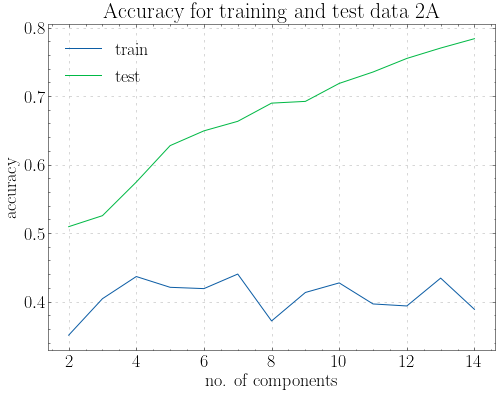

In [198]:
plt.plot(Q,df.iloc[:,2],label="train")
plt.plot(Q,df.iloc[:,1],label = "test")
plt.title("Accuracy for training and test data 2A")
plt.xlabel("no. of components")
plt.ylabel("accuracy")
plt.legend()
plt.savefig("acc_2a.png")
plt.show()

In [132]:
Q[5]

7

In [157]:
X_test = mountain_test
ln = len(X_test)

Y_test = np.array([4]*ln)
X_cv,X_test,y_cv,y_test = train_test_split(X_test,Y_test, test_size=0.3, random_state=2)
ln = len(X_test)
X = X_test
i = 5
gmm0 = gmm_list[0][i]
gmm1 = gmm_list[1][i]
gmm2 = gmm_list[2][i]
gmm3 = gmm_list[3][i]
gmm4 = gmm_list[4][i]

# Training
a = gmm0.indv_log_likelihood(X)
b = gmm1.indv_log_likelihood(X)
c = gmm2.indv_log_likelihood(X)
d = gmm3.indv_log_likelihood(X)
e = gmm4.indv_log_likelihood(X)

f = np.hstack((a, b, c, d, e))
pred = np.argmax(f, axis=1)

acc_calc = accuracy.Confusion_matrix(pred,y_test)
acc_test.append(acc_calc.accuracy)
#o_acc_cv = acc_cv

In [158]:
np.mean(np.array(acc_test))

0.3784189723320159

In [149]:
X_train = coast_train
X_train = X_train.append([highway_train,tallbuilding_train,opencountry_train,mountain_train])

In [164]:
#predicting training data - selecting max likelihood value
Y_train = [[0]*len(coast_train),[1]*len(highway_train),[2]*len(tallbuilding_train),[3]*len(opencountry_train),[4]*len(mountain_train)]
X = X_train
#ln = len(X)
#Y_train = np.array([4]*ln)
acc_train = []
i = 5
gmm0 = gmm_list[0][i]
gmm1 = gmm_list[1][i]
gmm2 = gmm_list[2][i]
gmm3 = gmm_list[3][i]
gmm4 = gmm_list[4][i]

# Training
a = gmm0.indv_log_likelihood(X)
b = gmm1.indv_log_likelihood(X)
c = gmm2.indv_log_likelihood(X)
d = gmm3.indv_log_likelihood(X)
e = gmm4.indv_log_likelihood(X)

f = np.hstack((a, b, c, d, e))
pred = np.argmax(f, axis=1)

TypeError: unhashable type: 'list'

In [183]:
flat_list = [item for sublist in Y_train for item in sublist]
pd.DataFrame(confusion_matrix(pred,flat_list)).to_csv("conf_train_2a.csv")

In [193]:
X_test = coast_test 
X_test  = X_test.append([highway_test,tallbuilding_test,opencountry_test,mountain_test])
Y_test = [[0]*len(coast_test),[1]*len(highway_test),[2]*len(tallbuilding_test),[3]*len(opencountry_test),[4]*len(mountain_test)]

In [194]:
X = X_test
i = 5
gmm0 = gmm_list[0][i]
gmm1 = gmm_list[1][i]
gmm2 = gmm_list[2][i]
gmm3 = gmm_list[3][i]
gmm4 = gmm_list[4][i]

# Training
a = gmm0.indv_log_likelihood(X)
b = gmm1.indv_log_likelihood(X)
c = gmm2.indv_log_likelihood(X)
d = gmm3.indv_log_likelihood(X)
e = gmm4.indv_log_likelihood(X)

f = np.hstack((a, b, c, d, e))
pred = np.argmax(f, axis=1)


In [195]:
flat_list = [item for sublist in Y_test for item in sublist]
pd.DataFrame(confusion_matrix(pred,flat_list)).to_csv("conf_test_2a.csv")